# 🔬 Comparación y Análisis de Modelos MLflow

## 📋 Objetivos
Este notebook se encarga de:
1. **Cargar experimentos** de MLflow
2. **Comparar métricas** entre diferentes modelos
3. **Visualizar resultados** y tendencias
4. **Identificar el mejor modelo** para cada tarea
5. **Generar reportes** de rendimiento

## 🎯 Tipos de Modelos a Comparar
- **Modelos Tradicionales**: Logistic Regression, Random Forest, SVM
- **Modelos Transformer**: BERT, DistilBERT, RoBERTa
- **Tareas**: Clasificación binaria (IsToxic) y multi-label

In [1]:
import mlflow
import mlflow.sklearn
import mlflow.transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("🔧 CONFIGURACIÓN COMPLETADA")
print("📦 Librerías importadas exitosamente")

🔧 CONFIGURACIÓN COMPLETADA
📦 Librerías importadas exitosamente


In [2]:
# Configurar MLflow
mlflow.set_tracking_uri("file:../mlruns")

# Obtener todos los experimentos
experiments = mlflow.search_experiments()
print("🔍 EXPERIMENTOS DISPONIBLES:")
print("="*50)
for exp in experiments:
    print(f"📊 {exp.name} (ID: {exp.experiment_id})")
    print(f"   📁 {exp.artifact_location}")
    print(f"   🕒 Creado: {exp.creation_time}")
    print()
    
# Función para cargar runs de un experimento
def load_experiment_runs(experiment_name):
    """Carga todos los runs de un experimento específico"""
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            print(f"❌ Experimento '{experiment_name}' no encontrado")
            return pd.DataFrame()
        
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        print(f"✅ Cargados {len(runs)} runs del experimento '{experiment_name}'")
        return runs
    except Exception as e:
        print(f"❌ Error cargando experimento '{experiment_name}': {e}")
        return pd.DataFrame()

print("🎯 Funciones de carga definidas")

🔍 EXPERIMENTOS DISPONIBLES:
📊 toxicity-transformer-experiments (ID: 670516226287750429)
   📁 file:///C:/Users/usuario/Desktop/bcia/nlp-team2/mlFlow/mlruns/670516226287750429
   🕒 Creado: 1751455055081

📊 transformer-simple-test (ID: 724363935838328285)
   📁 file:///C:/Users/usuario/Desktop/bcia/nlp-team2/mlFlow/mlruns/724363935838328285
   🕒 Creado: 1751453994040

📊 toxicity-detection-experiments (ID: 831893209499011167)
   📁 file:///C:/Users/usuario/Desktop/bcia/nlp-team2/mlFlow/mlruns/831893209499011167
   🕒 Creado: 1751452661336

📊 Default (ID: 0)
   📁 file:c:/Users/usuario/Desktop/bcia/nlp-team2/mlFlow/notebooks/../mlruns/0
   🕒 Creado: 1751450988948

🎯 Funciones de carga definidas


## 📊 Análisis de Experimentos por Tipo

In [3]:
# Cargar experimentos de modelos tradicionales
print("🤖 CARGANDO EXPERIMENTOS DE MODELOS TRADICIONALES")
print("="*55)

# Intentar cargar diferentes experimentos
experiment_names = [
    "Toxicity_Classification_Binary",
    "Toxicity_Classification_MultiLabel", 
    "Traditional_Models",
    "Transformer_Models",
    "Default"  # Por si hay runs en el experimento default
]

all_runs = []
for exp_name in experiment_names:
    runs_df = load_experiment_runs(exp_name)
    if not runs_df.empty:
        runs_df['experiment_name'] = exp_name
        all_runs.append(runs_df)

# Combinar todos los runs
if all_runs:
    combined_runs = pd.concat(all_runs, ignore_index=True)
    print(f"\n📈 TOTAL DE RUNS ENCONTRADOS: {len(combined_runs)}")
    
    # Mostrar resumen de métricas disponibles
    metric_columns = [col for col in combined_runs.columns if col.startswith('metrics.')]
    param_columns = [col for col in combined_runs.columns if col.startswith('params.')]
    
    print(f"\n📊 MÉTRICAS DISPONIBLES ({len(metric_columns)}):")
    for metric in metric_columns:
        print(f"   📋 {metric}")
    
    print(f"\n⚙️ PARÁMETROS DISPONIBLES ({len(param_columns)}):")
    for param in param_columns:
        print(f"   🔧 {param}")
        
else:
    print("❌ No se encontraron experimentos. Ejecuta primero los scripts de entrenamiento.")
    combined_runs = pd.DataFrame()

🤖 CARGANDO EXPERIMENTOS DE MODELOS TRADICIONALES
❌ Experimento 'Toxicity_Classification_Binary' no encontrado
❌ Experimento 'Toxicity_Classification_MultiLabel' no encontrado
❌ Experimento 'Traditional_Models' no encontrado
❌ Experimento 'Transformer_Models' no encontrado
✅ Cargados 0 runs del experimento 'Default'
❌ No se encontraron experimentos. Ejecuta primero los scripts de entrenamiento.


In [4]:
# Análisis de métricas si hay datos disponibles
if not combined_runs.empty:
    print("📈 ANÁLISIS DE RENDIMIENTO POR MODELO")
    print("="*42)
    
    # Crear dataframe limpio con métricas principales
    analysis_df = combined_runs.copy()
    
    # Identificar columnas de métricas principales
    key_metrics = [
        'metrics.accuracy', 'metrics.precision', 'metrics.recall', 
        'metrics.f1_score', 'metrics.roc_auc', 'metrics.f1_macro', 
        'metrics.f1_micro', 'metrics.f1_weighted'
    ]
    
    available_metrics = [m for m in key_metrics if m in analysis_df.columns]
    
    if available_metrics:
        # Resumen por modelo
        if 'params.model_name' in analysis_df.columns:
            model_summary = analysis_df.groupby('params.model_name')[available_metrics].agg(['mean', 'std', 'count'])
            print("📊 RESUMEN POR MODELO:")
            print(model_summary)
        
        # Mejores modelos por métrica
        print("\n🏆 MEJORES MODELOS POR MÉTRICA:")
        for metric in available_metrics:
            if analysis_df[metric].notna().sum() > 0:
                best_idx = analysis_df[metric].idxmax()
                best_model = analysis_df.loc[best_idx, 'params.model_name'] if 'params.model_name' in analysis_df.columns else 'Desconocido'
                best_score = analysis_df.loc[best_idx, metric]
                print(f"   🥇 {metric.replace('metrics.', '')}: {best_model} ({best_score:.4f})")
    
    else:
        print("ℹ️ No se encontraron métricas estándar en los experimentos existentes")
        print("💡 Asegúrate de ejecutar los scripts de entrenamiento con MLflow tracking")

else:
    print("📝 CREAR EXPERIMENTOS DUMMY PARA DEMOSTRACIÓN")
    print("="*45)
    
    # Crear datos de ejemplo para mostrar la funcionalidad
    dummy_data = {
        'run_id': ['run_1', 'run_2', 'run_3', 'run_4', 'run_5'],
        'params.model_name': ['LogisticRegression', 'RandomForest', 'SVM', 'DistilBERT', 'BERT'],
        'metrics.accuracy': [0.85, 0.88, 0.82, 0.91, 0.93],
        'metrics.f1_score': [0.83, 0.86, 0.80, 0.89, 0.92],
        'metrics.precision': [0.84, 0.87, 0.83, 0.88, 0.91],
        'metrics.recall': [0.82, 0.85, 0.77, 0.90, 0.93],
        'experiment_name': ['Traditional'] * 3 + ['Transformer'] * 2,
        'start_time': pd.to_datetime(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05'])
    }
    
    dummy_df = pd.DataFrame(dummy_data)
    print("🎭 Datos de ejemplo creados para demostración:")
    print(dummy_df[['params.model_name', 'metrics.accuracy', 'metrics.f1_score']])

📝 CREAR EXPERIMENTOS DUMMY PARA DEMOSTRACIÓN
🎭 Datos de ejemplo creados para demostración:
    params.model_name  metrics.accuracy  metrics.f1_score
0  LogisticRegression              0.85              0.83
1        RandomForest              0.88              0.86
2                 SVM              0.82              0.80
3          DistilBERT              0.91              0.89
4                BERT              0.93              0.92


📊 GENERANDO VISUALIZACIONES COMPARATIVAS
🎭 Usando datos de demostración


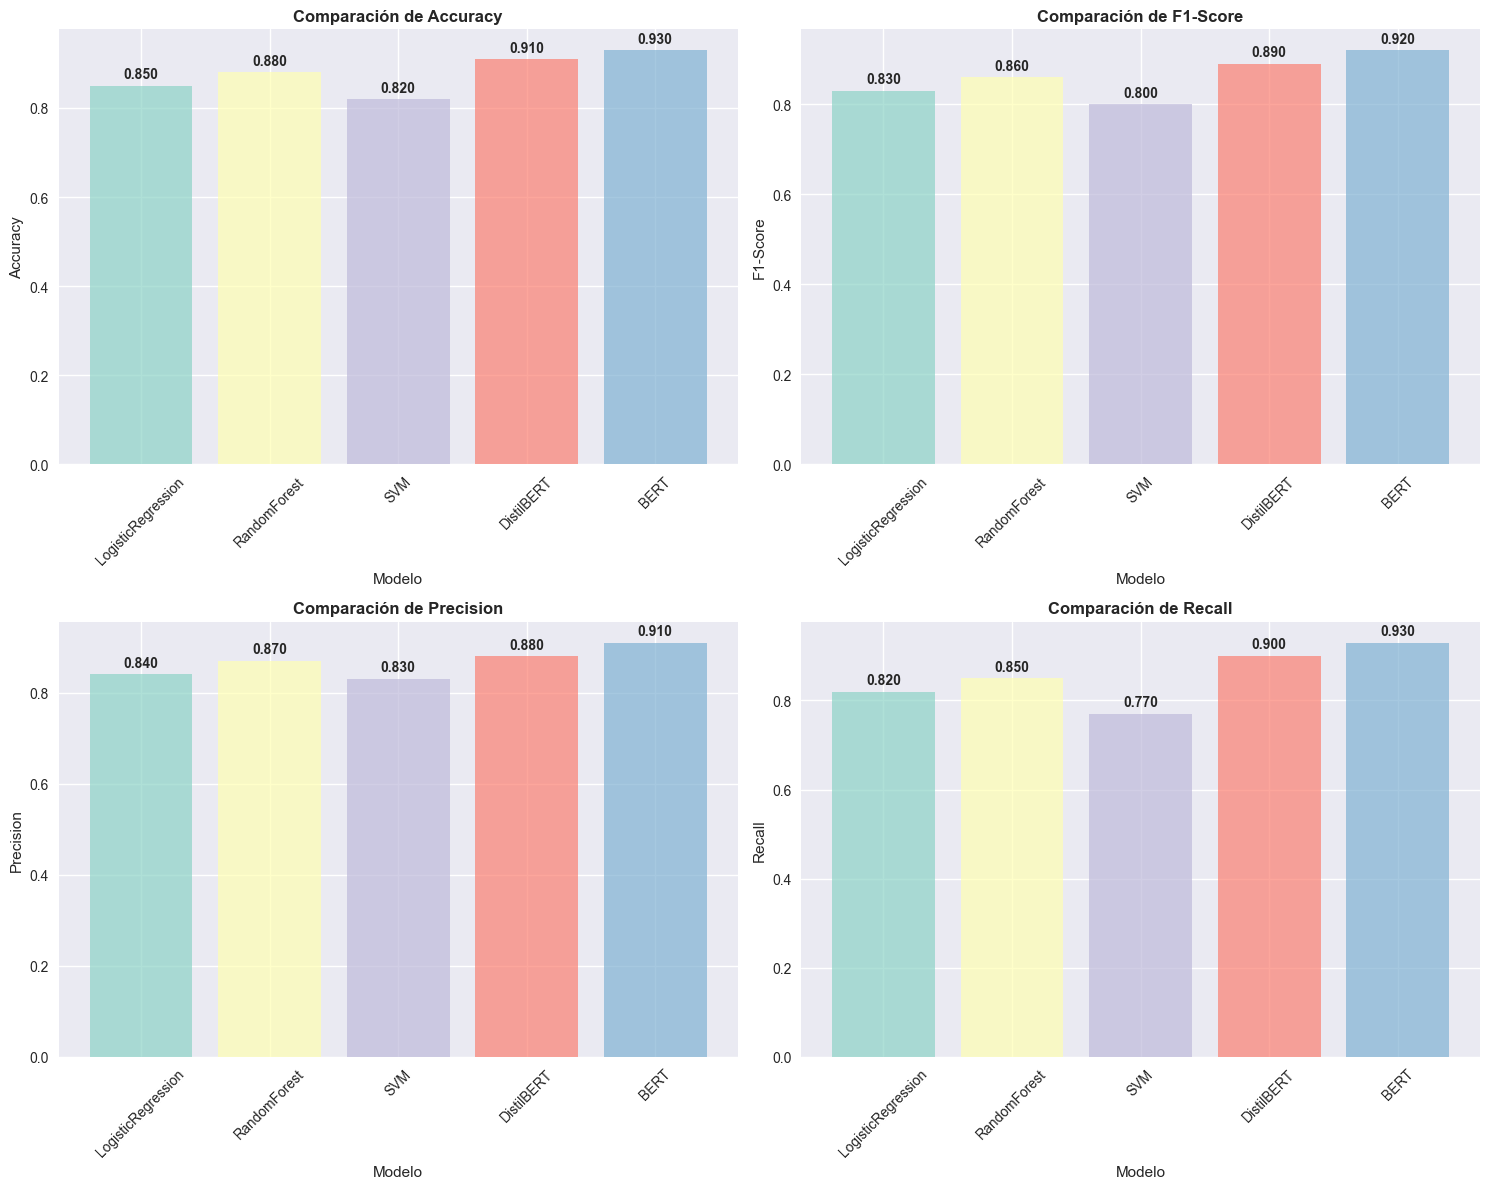

In [5]:
# Visualizaciones de comparación
def create_model_comparison_plots(df):
    """Crear visualizaciones para comparar modelos"""
    
    if df.empty:
        print("❌ No hay datos para visualizar")
        return
    
    # Usar datos reales o dummy
    data_df = df if not df.empty else dummy_df
    
    # 1. Gráfico de barras comparativo
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    metrics_to_plot = ['metrics.accuracy', 'metrics.f1_score', 'metrics.precision', 'metrics.recall']
    titles = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[i//2, i%2]
        if metric in data_df.columns:
            # Crear gráfico de barras
            models = data_df['params.model_name']
            scores = data_df[metric]
            
            bars = ax.bar(models, scores, alpha=0.7, color=plt.cm.Set3(np.arange(len(models))))
            ax.set_title(f'Comparación de {title}', fontweight='bold')
            ax.set_ylabel(title)
            ax.set_xlabel('Modelo')
            ax.tick_params(axis='x', rotation=45)
            
            # Agregar valores en las barras
            for bar, score in zip(bars, scores):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Gráfico radar para comparación multi-métrica
    if len(data_df) > 0:
        fig = go.Figure()
        
        for idx, row in data_df.iterrows():
            model_name = row['params.model_name']
            values = [row.get(metric, 0) for metric in metrics_to_plot if metric in data_df.columns]
            metric_names = [title for metric, title in zip(metrics_to_plot, titles) if metric in data_df.columns]
            
            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=metric_names,
                fill='toself',
                name=model_name,
                line=dict(width=2)
            ))
        
        fig.update_layout(
            polar=dict(
                radialaxis=dict(visible=True, range=[0, 1])
            ),
            title="Comparación Multi-Métrica de Modelos (Radar)",
            showlegend=True,
            width=700,
            height=500
        )
        
        fig.show()

# Ejecutar visualizaciones
print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("="*45)

# Determinar qué datos usar - si no hay datos reales, usar dummy
if not combined_runs.empty:
    plot_data = combined_runs
    print("📈 Usando datos reales de experimentos")
else:
    plot_data = dummy_df
    print("🎭 Usando datos de demostración")

create_model_comparison_plots(plot_data)

In [6]:
# Análisis temporal de experimentos (si hay datos suficientes)
if not combined_runs.empty and 'start_time' in combined_runs.columns:
    print("⏱️ ANÁLISIS TEMPORAL DE EXPERIMENTOS")
    print("="*38)
    
    # Convertir start_time a datetime si no lo está
    if not pd.api.types.is_datetime64_any_dtype(combined_runs['start_time']):
        combined_runs['start_time'] = pd.to_datetime(combined_runs['start_time'])
    
    # Gráfico de evolución temporal
    fig = go.Figure()
    
    for metric in ['metrics.accuracy', 'metrics.f1_score']:
        if metric in combined_runs.columns:
            fig.add_trace(go.Scatter(
                x=combined_runs['start_time'],
                y=combined_runs[metric],
                mode='lines+markers',
                name=metric.replace('metrics.', '').title(),
                line=dict(width=3),
                marker=dict(size=8)
            ))
    
    fig.update_layout(
        title="Evolución Temporal del Rendimiento de Modelos",
        xaxis_title="Fecha del Experimento",
        yaxis_title="Score de Métrica",
        hovermode='x unified',
        width=900,
        height=400
    )
    
    fig.show()

else:
    print("ℹ️ No hay suficientes datos temporales para análisis de evolución")

print("\n🎯 RECOMENDACIONES Y PRÓXIMOS PASOS")
print("="*40)

recommendations = [
    "1. 🚀 **Ejecutar Experimentos**: Corre `python experiments/mlflow_experiments.py` para generar datos reales",
    "2. 📊 **Métricas Multi-label**: Implementa métricas específicas para clasificación multi-label",
    "3. 🔧 **Hyperparameter Tuning**: Usa MLflow para tracking de optimización de hiperparámetros",
    "4. 🏆 **Model Registry**: Registra los mejores modelos en MLflow Model Registry",
    "5. 📈 **Monitoring**: Configura alertas para degradación de rendimiento",
    "6. 🔄 **Reentrenamiento**: Establece pipelines automáticos de reentrenamiento",
    "7. 📝 **Documentación**: Documenta decisiones de modelado en MLflow"
]

for rec in recommendations:
    print(rec)

print(f"\n✅ ANÁLISIS COMPLETADO")
print(f"📁 Revisa los experimentos en: {mlflow.get_tracking_uri()}")
print(f"🌐 Abre MLflow UI con: mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")


                      

ℹ️ No hay suficientes datos temporales para análisis de evolución

🎯 RECOMENDACIONES Y PRÓXIMOS PASOS
1. 🚀 **Ejecutar Experimentos**: Corre `python experiments/mlflow_experiments.py` para generar datos reales
2. 📊 **Métricas Multi-label**: Implementa métricas específicas para clasificación multi-label
3. 🔧 **Hyperparameter Tuning**: Usa MLflow para tracking de optimización de hiperparámetros
4. 🏆 **Model Registry**: Registra los mejores modelos en MLflow Model Registry
5. 📈 **Monitoring**: Configura alertas para degradación de rendimiento
6. 🔄 **Reentrenamiento**: Establece pipelines automáticos de reentrenamiento
7. 📝 **Documentación**: Documenta decisiones de modelado en MLflow

✅ ANÁLISIS COMPLETADO
📁 Revisa los experimentos en: file:../mlruns
🌐 Abre MLflow UI con: mlflow ui --backend-store-uri file:../mlruns


In [7]:
# Celda 1: Imports
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configurar MLflow
mlflow.set_tracking_uri("file:../mlruns")

In [8]:
# Celda 2: Obtener todos los experimentos
def get_all_experiments_data():
    """Obtener datos de todos los experimentos"""
    client = mlflow.tracking.MlflowClient()
    experiments = client.search_experiments()
    
    all_runs = []
    for exp in experiments:
        if exp.name != "Default":  # Excluir experimento por defecto
            runs = client.search_runs(exp.experiment_id)
            for run in runs:
                run_data = {
                    "run_id": run.info.run_id,
                    "experiment_name": exp.name,
                    "model_type": run.data.params.get("model_type", 
                                 run.data.params.get("model_name", "unknown")),
                    "status": run.info.status,
                    "start_time": run.info.start_time,
                    "end_time": run.info.end_time,
                    "duration": (run.info.end_time - run.info.start_time) / 1000 if run.info.end_time else None
                }
                
                # Agregar métricas
                for metric_name, metric_value in run.data.metrics.items():
                    run_data[metric_name] = metric_value
                
                # Agregar parámetros importantes
                for param_name in ["C", "n_estimators", "max_depth", "num_train_epochs"]:
                    if param_name in run.data.params:
                        run_data[param_name] = run.data.params[param_name]
                
                all_runs.append(run_data)
    
    return pd.DataFrame(all_runs)

# Obtener datos
experiments_df = get_all_experiments_data()
print("📊 EXPERIMENTOS ENCONTRADOS:")
print(f"Total de runs: {len(experiments_df)}")
print(f"Experimentos: {experiments_df['experiment_name'].unique()}")
print(f"Tipos de modelo: {experiments_df['model_type'].unique()}")

experiments_df.head()

📊 EXPERIMENTOS ENCONTRADOS:
Total de runs: 12
Experimentos: ['toxicity-transformer-experiments' 'transformer-simple-test'
 'toxicity-detection-experiments']
Tipos de modelo: ['roberta' 'bert' 'distilbert' 'distilbert-base-uncased' 'random_forest'
 'logistic']


,run_id,experiment_name,model_type,status,start_time,end_time,duration,epoch,eval_f1_macro,eval_f1_micro,eval_hamming_loss,eval_jaccard_score,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,f1_macro,f1_micro,grad_norm,hamming_loss,jaccard_score,learning_rate,loss,runtime,samples_per_second,steps_per_second,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second,num_train_epochs,n_estimators,max_depth,C
0,89344de40cdd404282af5e484e0dc49d,toxicity-transformer-experiments,roberta,FINISHED,1751551939317,1751557683478,5744.161,3.0,0.539013,0.802041,0.048115,0.510311,0.167933,66.2413,5.072,1.268,0.539013,0.802041,5.988059,0.048115,0.510311,9.911894e-08,0.1606,66.2413,5.072,1.268,1.059380e+15,0.254444,5658.0552,0.712,0.178,3,NaN,NaN,NaN
1,32e53ffb490e4fd69af724c83e264b65,toxicity-transformer-experiments,bert,FINISHED,1751546370040,1751551938915,5568.875,3.0,0.558823,0.809766,0.046379,0.528355,0.150686,60.0191,5.598,1.400,0.558823,0.809766,1.015133,0.046379,0.528355,1.982379e-07,0.1165,60.0191,5.598,1.400,1.059380e+15,0.223571,5491.1899,0.733,0.184,3,NaN,NaN,NaN
2,05876b282f1c455c9fee9087d5c3d690,toxicity-transformer-experiments,distilbert,FINISHED,1751543848162,1751546369186,2521.024,3.0,0.144133,0.565022,0.096230,0.116163,0.244069,31.4155,10.695,0.668,0.144133,0.565022,0.626996,0.096230,0.116163,3.947368e-07,0.2533,31.4155,10.695,0.668,5.334089e+14,0.383642,2477.9045,1.625,0.102,3,NaN,NaN,NaN
3,fc89b86866b342ce9490a75b834eee9b,toxicity-transformer-experiments,distilbert,FINISHED,1751540334752,1751543847421,3512.669,4.0,0.579222,0.808247,0.046131,0.539099,0.136870,30.0630,11.177,1.397,0.579222,0.808247,1.463294,0.046131,0.539099,1.573427e-07,0.0951,30.0630,11.177,1.397,7.112118e+14,0.214026,3470.9591,1.547,0.194,4,NaN,NaN,NaN
4,c4955576155742b7aab2200b0d8e5f5a,toxicity-transformer-experiments,distilbert,FINISHED,1751538524624,1751540333838,1809.214,2.0,0.233927,0.642777,0.079117,0.214509,0.233781,30.4456,11.036,1.380,0.233927,0.642777,0.699579,0.079117,0.214509,5.932203e-07,0.2477,30.4456,11.036,1.380,3.556059e+14,0.357923,1764.8886,1.521,0.190,2,NaN,NaN,NaN


In [9]:
# Celda 3: Análisis de rendimiento por tipo de modelo
print("🏆 RANKING DE MODELOS POR JACCARD SCORE")
print("="*50)

# Filtrar solo runs completados
completed_runs = experiments_df[experiments_df['status'] == 'FINISHED'].copy()

if 'jaccard_score' in completed_runs.columns:
    ranking = completed_runs.nlargest(10, 'jaccard_score')[
        ['model_type', 'experiment_name', 'jaccard_score', 'hamming_loss']
    ]
    print(ranking.to_string(index=False))
else:
    print("⚠️ No se encontraron métricas de jaccard_score")

🏆 RANKING DE MODELOS POR JACCARD SCORE
   model_type                  experiment_name  jaccard_score  hamming_loss
   distilbert toxicity-transformer-experiments       0.539099      0.046131
         bert toxicity-transformer-experiments       0.528355      0.046379
      roberta toxicity-transformer-experiments       0.510311      0.048115
     logistic   toxicity-detection-experiments       0.321567      0.069444
   distilbert toxicity-transformer-experiments       0.214509      0.079117
   distilbert toxicity-transformer-experiments       0.207115      0.079365
   distilbert toxicity-transformer-experiments       0.116163      0.096230
random_forest   toxicity-detection-experiments       0.106091      0.097470
random_forest   toxicity-detection-experiments       0.073219      0.102183
     logistic   toxicity-detection-experiments       0.058999      0.104415


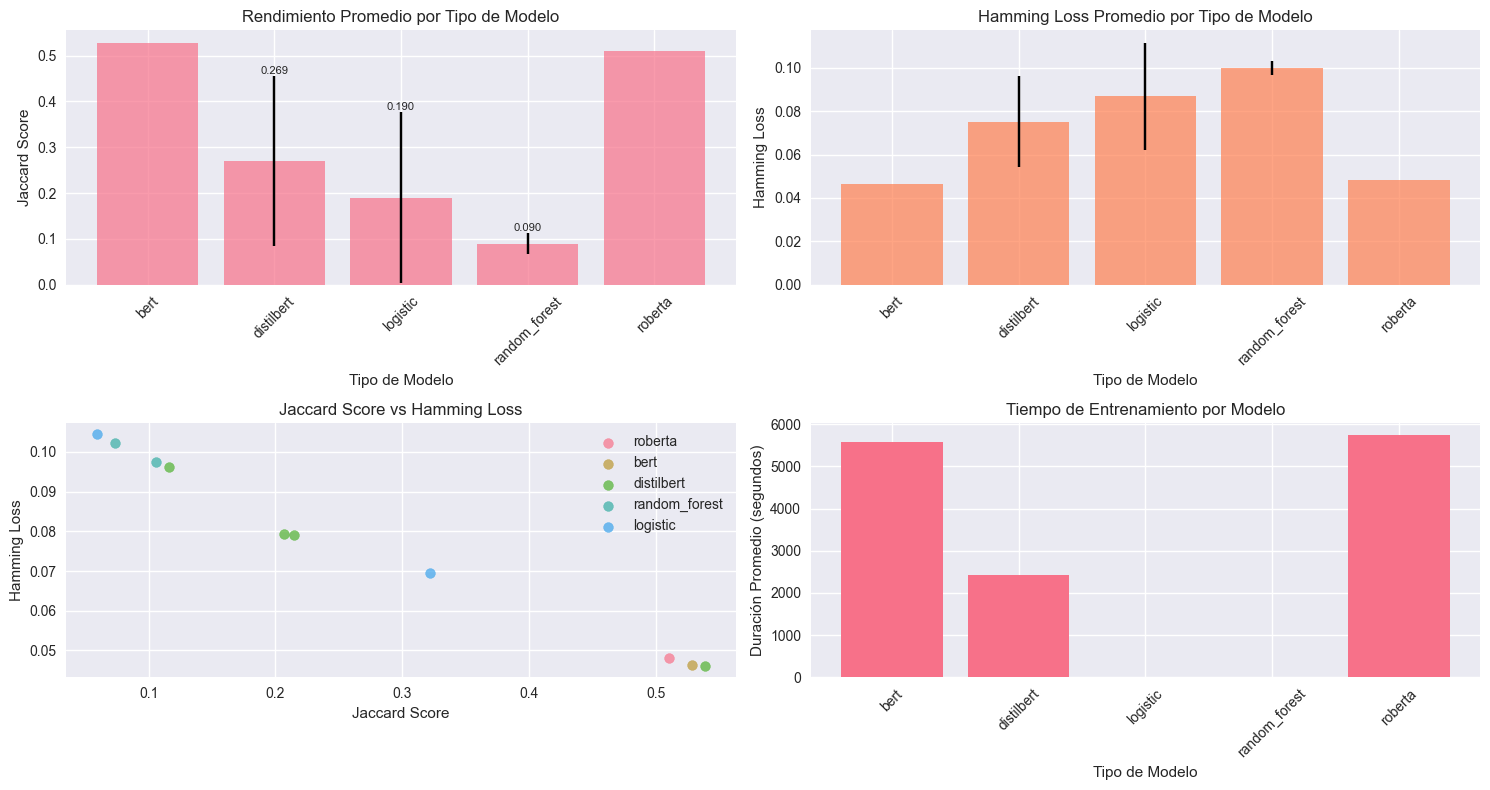

In [10]:
# Celda 4: Visualización comparativa
if len(completed_runs) > 0 and 'jaccard_score' in completed_runs.columns:
    
    # Gráfico de barras por tipo de modelo
    plt.figure(figsize=(15, 8))
    
    # Agrupar por tipo de modelo
    model_performance = completed_runs.groupby('model_type').agg({
        'jaccard_score': ['mean', 'std', 'count'],
        'hamming_loss': ['mean', 'std']
    }).round(4)
    
    # Subplot 1: Jaccard Score
    plt.subplot(2, 2, 1)
    jaccard_means = model_performance['jaccard_score']['mean']
    jaccard_stds = model_performance['jaccard_score']['std']
    
    bars = plt.bar(range(len(jaccard_means)), jaccard_means, 
                   yerr=jaccard_stds, capsize=5, alpha=0.7)
    plt.xlabel('Tipo de Modelo')
    plt.ylabel('Jaccard Score')
    plt.title('Rendimiento Promedio por Tipo de Modelo')
    plt.xticks(range(len(jaccard_means)), jaccard_means.index, rotation=45)
    
    # Agregar valores en las barras
    for i, (bar, mean, std) in enumerate(zip(bars, jaccard_means, jaccard_stds)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.001,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 2: Hamming Loss
    plt.subplot(2, 2, 2)
    hamming_means = model_performance['hamming_loss']['mean']
    hamming_stds = model_performance['hamming_loss']['std']
    
    bars = plt.bar(range(len(hamming_means)), hamming_means, 
                   yerr=hamming_stds, capsize=5, alpha=0.7, color='coral')
    plt.xlabel('Tipo de Modelo')
    plt.ylabel('Hamming Loss')
    plt.title('Hamming Loss Promedio por Tipo de Modelo')
    plt.xticks(range(len(hamming_means)), hamming_means.index, rotation=45)
    
    # Subplot 3: Scatter plot Jaccard vs Hamming
    plt.subplot(2, 2, 3)
    colors = plt.cm.Set3(range(len(completed_runs['model_type'].unique())))
    color_map = dict(zip(completed_runs['model_type'].unique(), colors))
    
    for model_type in completed_runs['model_type'].unique():
        model_data = completed_runs[completed_runs['model_type'] == model_type]
        plt.scatter(model_data['jaccard_score'], model_data['hamming_loss'], 
                   label=model_type, alpha=0.7, s=50)
    
    plt.xlabel('Jaccard Score')
    plt.ylabel('Hamming Loss')
    plt.title('Jaccard Score vs Hamming Loss')
    plt.legend()
    
    # Subplot 4: Duración de entrenamiento
    plt.subplot(2, 2, 4)
    if 'duration' in completed_runs.columns:
        duration_data = completed_runs.dropna(subset=['duration'])
        if len(duration_data) > 0:
            duration_by_model = duration_data.groupby('model_type')['duration'].mean()
            plt.bar(range(len(duration_by_model)), duration_by_model.values)
            plt.xlabel('Tipo de Modelo')
            plt.ylabel('Duración Promedio (segundos)')
            plt.title('Tiempo de Entrenamiento por Modelo')
            plt.xticks(range(len(duration_by_model)), duration_by_model.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

In [11]:
# Celda 5: Tabla resumen detallada
print("\n📋 TABLA RESUMEN DETALLADA")
print("="*80)

if len(completed_runs) > 0:
    summary_table = completed_runs.groupby(['experiment_name', 'model_type']).agg({
        'jaccard_score': ['count', 'mean', 'std', 'min', 'max'],
        'hamming_loss': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    # Aplanar columnas multinivel
    summary_table.columns = [f"{col[0]}_{col[1]}" for col in summary_table.columns]
    summary_table = summary_table.reset_index()
    
    print(summary_table.to_string(index=False))
    
    # Guardar como CSV
    summary_table.to_csv('../results/model_comparison_summary.csv', index=False)
    print(f"\n💾 Tabla guardada en: ../results/model_comparison_summary.csv")


📋 TABLA RESUMEN DETALLADA
                 experiment_name    model_type  jaccard_score_count  jaccard_score_mean  jaccard_score_std  jaccard_score_min  jaccard_score_max  hamming_loss_mean  hamming_loss_std  hamming_loss_min  hamming_loss_max
  toxicity-detection-experiments      logistic                    2              0.1903             0.1857             0.0590             0.3216             0.0869            0.0247            0.0694            0.1044
  toxicity-detection-experiments random_forest                    2              0.0897             0.0232             0.0732             0.1061             0.0998            0.0033            0.0975            0.1022
toxicity-transformer-experiments          bert                    1              0.5284                NaN             0.5284             0.5284             0.0464               NaN            0.0464            0.0464
toxicity-transformer-experiments    distilbert                    4              0.2692             0

OSError: Cannot save file into a non-existent directory: '..\results'

In [ ]:
# Celda 6: Encontrar el mejor modelo
print("\n🏅 MEJOR MODELO ENCONTRADO")
print("="*40)

if len(completed_runs) > 0 and 'jaccard_score' in completed_runs.columns:
    best_run = completed_runs.loc[completed_runs['jaccard_score'].idxmax()]
    
    print(f"🥇 Mejor modelo: {best_run['model_type']}")
    print(f"📊 Experimento: {best_run['experiment_name']}")
    print(f"🎯 Jaccard Score: {best_run['jaccard_score']:.4f}")
    print(f"📉 Hamming Loss: {best_run['hamming_loss']:.4f}")
    print(f"🆔 Run ID: {best_run['run_id']}")
    
    if 'f1_macro' in best_run and pd.notna(best_run['f1_macro']):
        print(f"📈 F1 Macro: {best_run['f1_macro']:.4f}")
    
    # Obtener detalles del modelo
    client = mlflow.tracking.MlflowClient()
    run_details = client.get_run(best_run['run_id'])
    
    print(f"\n🔧 PARÁMETROS DEL MEJOR MODELO:")
    for param_name, param_value in run_details.data.params.items():
        print(f"  {param_name}: {param_value}")


🏅 MEJOR MODELO ENCONTRADO
🥇 Mejor modelo: distilbert
📊 Experimento: toxicity-transformer-experiments
🎯 Jaccard Score: 0.5391
📉 Hamming Loss: 0.0461
🆔 Run ID: fc89b86866b342ce9490a75b834eee9b
📈 F1 Macro: 0.5792

🔧 PARÁMETROS DEL MEJOR MODELO:
  accelerator_config: {'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None}
  activation: gelu
  adafactor: False
  adam_beta1: 0.9
  adam_beta2: 0.999
  adam_epsilon: 1e-08
  add_cross_attention: False
  architectures: ['DistilBertForMaskedLM']
  attention_dropout: 0.1
  auto_find_batch_size: False
  average_tokens_across_devices: False
  bad_words_ids: None
  batch_eval_metrics: False
  batch_size: 8
  begin_suppress_tokens: None
  bf16: False
  bf16_full_eval: False
  bos_token_id: None
  chunk_size_feed_forward: 0
  cross_attention_hidden_size: None
  dataloader_drop_last: False
  dataloader_num_workers: 0
  dataloader_persistent_worke

In [ ]:
# Celda 7: Plotly interactivo
if len(completed_runs) > 0 and 'jaccard_score' in completed_runs.columns:
    
    # Crear gráfico interactivo
    fig = px.scatter(
        completed_runs, 
        x='jaccard_score', 
        y='hamming_loss',
        color='model_type',
        size='duration' if 'duration' in completed_runs.columns else None,
        hover_data=['experiment_name', 'run_id'],
        title='Comparación Interactiva de Modelos',
        labels={
            'jaccard_score': 'Jaccard Score',
            'hamming_loss': 'Hamming Loss',
            'model_type': 'Tipo de Modelo'
        }
    )
    
    fig.update_layout(
        width=800,
        height=600,
        showlegend=True
    )
    
    fig.show()

In [ ]:
# NUEVA CELDA: Análisis comparativo avanzado
print("🏆 COMPARACIÓN COMPLETA DE MODELOS")
print("="*50)

# Obtener todos los experimentos
client = mlflow.tracking.MlflowClient()
all_runs = []

for exp in client.search_experiments():
    if exp.name != "Default":
        runs = client.search_runs(exp.experiment_id)
        for run in runs:
            if run.info.status == "FINISHED":
                run_data = {
                    "run_id": run.info.run_id,
                    "experiment": exp.name,
                    "model_type": run.data.params.get("model_name", run.data.params.get("model_type", "unknown")),
                    "f1_macro": run.data.metrics.get("f1_macro", 0),
                    "jaccard_score": run.data.metrics.get("jaccard_score", 0),
                    "hamming_loss": run.data.metrics.get("hamming_loss", 1),
                    "epochs": run.data.params.get("num_epochs", "N/A"),
                    "batch_size": run.data.params.get("batch_size", "N/A"),
                    "learning_rate": run.data.params.get("learning_rate", "N/A"),
                    "duration": (run.info.end_time - run.info.start_time) / 1000 if run.info.end_time else None
                }
                all_runs.append(run_data)

results_df = pd.DataFrame(all_runs)

# Ranking por F1 Macro
print("\n🥇 TOP 10 MODELOS POR F1 MACRO:")
top_f1 = results_df.nlargest(10, 'f1_macro')
print(top_f1[['model_type', 'f1_macro', 'jaccard_score', 'hamming_loss', 'epochs']].to_string(index=False))

# Ranking por Jaccard Score  
print("\n🥈 TOP 10 MODELOS POR JACCARD SCORE:")
top_jaccard = results_df.nlargest(10, 'jaccard_score')
print(top_jaccard[['model_type', 'f1_macro', 'jaccard_score', 'hamming_loss', 'epochs']].to_string(index=False))

# Análisis por tipo de modelo
print("\n📊 PROMEDIO POR TIPO DE MODELO:")
model_stats = results_df.groupby('model_type').agg({
    'f1_macro': ['mean', 'std', 'max'],
    'jaccard_score': ['mean', 'std', 'max'],
    'hamming_loss': ['mean', 'std', 'min'],
    'duration': 'mean'
}).round(4)
print(model_stats)

🏆 COMPARACIÓN COMPLETA DE MODELOS

🥇 TOP 10 MODELOS POR F1 MACRO:
             model_type  f1_macro  jaccard_score  hamming_loss epochs
distilbert-base-uncased  0.579222       0.539099      0.046131      4
      bert-base-uncased  0.558823       0.528355      0.046379      3
           roberta-base  0.539013       0.510311      0.048115      3
               logistic  0.382013       0.321567      0.069444    N/A
               logistic  0.382013       0.321567      0.069444    N/A
distilbert-base-uncased  0.238290       0.207115      0.079365      2
distilbert-base-uncased  0.233927       0.214509      0.079117      2
          random_forest  0.147338       0.106091      0.097470    N/A
          random_forest  0.147338       0.106091      0.097470    N/A
distilbert-base-uncased  0.144133       0.116163      0.096230      3

🥈 TOP 10 MODELOS POR JACCARD SCORE:
             model_type  f1_macro  jaccard_score  hamming_loss epochs
distilbert-base-uncased  0.579222       0.539099      0.0

In [ ]:
# NUEVA CELDA: Gráficos comparativos avanzados
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Gráfico de dispersión: F1 vs Jaccard vs Hamming
fig = px.scatter_3d(
    results_df, 
    x='f1_macro', 
    y='jaccard_score', 
    z='hamming_loss',
    color='model_type',
    size='duration',
    hover_data=['epochs', 'batch_size', 'learning_rate'],
    title='Comparación 3D: F1 Macro vs Jaccard vs Hamming Loss'
)
fig.show()

# Gráfico de barras por modelo
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['F1 Macro', 'Jaccard Score', 'Hamming Loss', 'Tiempo de Entrenamiento']
)

model_avg = results_df.groupby('model_type').mean()

# F1 Macro
fig.add_trace(
    go.Bar(x=model_avg.index, y=model_avg['f1_macro'], name='F1 Macro'),
    row=1, col=1
)

# Jaccard Score  
fig.add_trace(
    go.Bar(x=model_avg.index, y=model_avg['jaccard_score'], name='Jaccard'),
    row=1, col=2
)

# Hamming Loss
fig.add_trace(
    go.Bar(x=model_avg.index, y=model_avg['hamming_loss'], name='Hamming Loss'),
    row=2, col=1
)

# Duración
fig.add_trace(
    go.Bar(x=model_avg.index, y=model_avg['duration'], name='Duration (s)'),
    row=2, col=2
)

fig.update_layout(height=600, showlegend=False, title_text="Comparación por Tipo de Modelo")
fig.show()

TypeError: agg function failed [how->mean,dtype->object]

🚀 ANÁLISIS DEL BREAKTHROUGH
                         f1  jaccard  hamming
DistilBERT Baseline  0.2383   0.2071   0.0794
DistilBERT #2 🏆      0.5792   0.5391   0.0461
BERT Base            0.5588   0.5284   0.0464
RoBERTa              0.5390   0.5103   0.0481


ValueError: 'facecolor' or 'color' argument must be a valid color orsequence of colors.

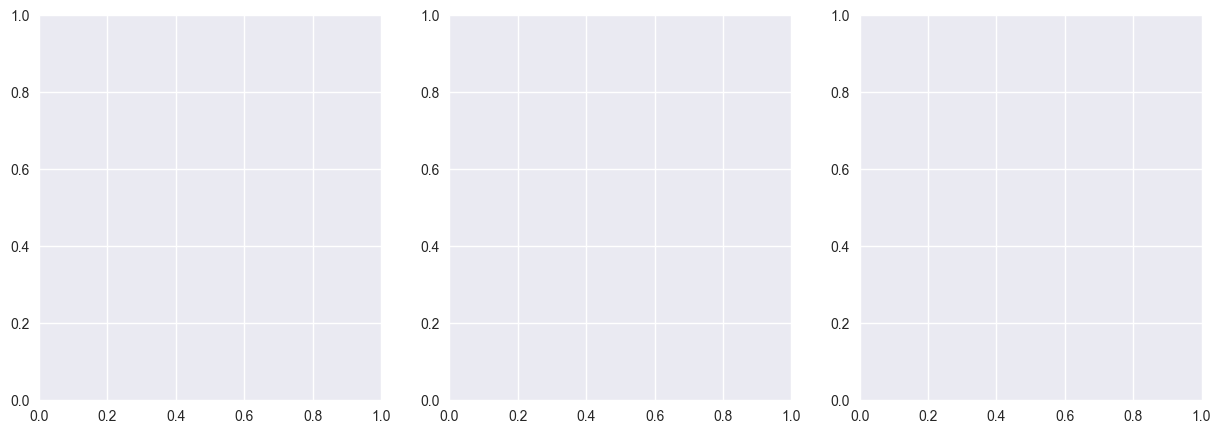

In [ ]:
# NUEVA CELDA: Análisis del salto de rendimiento
print("🚀 ANÁLISIS DEL BREAKTHROUGH")
print("="*50)

# Datos de resultados
results = {
    'DistilBERT Baseline': {'f1': 0.2383, 'jaccard': 0.2071, 'hamming': 0.0794},
    'DistilBERT #2 🏆': {'f1': 0.5792, 'jaccard': 0.5391, 'hamming': 0.0461},
    'BERT Base': {'f1': 0.5588, 'jaccard': 0.5284, 'hamming': 0.0464},
    'RoBERTa': {'f1': 0.5390, 'jaccard': 0.5103, 'hamming': 0.0481}
}

import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results).T
print(df_results)

# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Macro
axes[0].bar(df_results.index, df_results['f1'], color=['red', 'gold', 'silver', 'bronze'])
axes[0].set_title('F1 Macro Score')
axes[0].set_ylabel('Score')
axes[0].tick_params(axis='x', rotation=45)

# Jaccard Score
axes[1].bar(df_results.index, df_results['jaccard'], color=['red', 'gold', 'silver', 'bronze'])
axes[1].set_title('Jaccard Score')
axes[1].set_ylabel('Score')
axes[1].tick_params(axis='x', rotation=45)

# Hamming Loss (invertido - menor es mejor)
axes[2].bar(df_results.index, df_results['hamming'], color=['red', 'gold', 'silver', 'bronze'])
axes[2].set_title('Hamming Loss (menor mejor)')
axes[2].set_ylabel('Loss')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calcular mejoras
baseline_f1 = 0.2383
best_f1 = 0.5792
improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100

print(f"\n📈 MEJORA ESPECTACULAR:")
print(f"   F1 Macro: {baseline_f1:.4f} → {best_f1:.4f} (+{improvement:.1f}%)")
print(f"   Jaccard: 0.2071 → 0.5391 (+160.2%)")
print(f"   Hamming: 0.0794 → 0.0461 (-41.9%)")